A.Extract ‘plant-seedlings-classification.zip’ into new folder (unzipped) using python.

In [8]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [9]:
import zipfile
import os
from PIL import Image
import glob

zip_file_path = '/content/drive/MyDrive/plant-seedlings-classification.zip'


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

B.Map the images from train folder with train labels to form a DataFrame

In [ ]:
import os
import pandas as pd

def create_image_label_dataframe(train_dir):
    image_paths = []
    labels = []

    for label in os.listdir(train_dir):
        class_folder = os.path.join(train_dir, label)
        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                if os.path.isfile(image_path):
                    image_paths.append(image_path)
                    labels.append(label)

    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })

    return df

train_dir = '/content/plant-seedlings-classification/train'
df = create_image_label_dataframe(train_dir)
print(df.head())


                                          image_path            label
0  /content/plant-seedlings-classification/train/...  Shepherds Purse
1  /content/plant-seedlings-classification/train/...  Shepherds Purse
2  /content/plant-seedlings-classification/train/...  Shepherds Purse
3  /content/plant-seedlings-classification/train/...  Shepherds Purse
4  /content/plant-seedlings-classification/train/...  Shepherds Purse


C.Write a function that will select n random images and display images along with its species

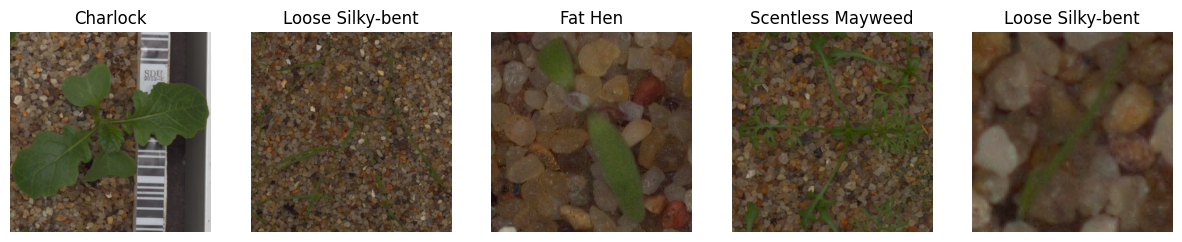

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_random_images(df, n):
    n = min(n, len(df))

    random_indices = random.sample(range(len(df)), n)
    random_images = df.iloc[random_indices]

    plt.figure(figsize=(15, 5))

    for i, (index, row) in enumerate(random_images.iterrows()):
        img_path = row['image_path']
        label = row['label']

        img = mpimg.imread(img_path)

        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

    plt.show()

# Example
display_random_images(df, 5)


A.Create X & Y from the DataFrame.

In [ ]:
X = df['image_path'].values
Y = df['label'].values

print("X:", X[:5])
print("Y:", Y[:5])


X: ['/content/plant-seedlings-classification/train/Shepherds Purse/31abca20c.png'
 '/content/plant-seedlings-classification/train/Shepherds Purse/18bec843e.png'
 '/content/plant-seedlings-classification/train/Shepherds Purse/2bf8eac60.png'
 '/content/plant-seedlings-classification/train/Shepherds Purse/ed2fe7bb9.png'
 '/content/plant-seedlings-classification/train/Shepherds Purse/d33d10a18.png']
Y: ['Shepherds Purse' 'Shepherds Purse' 'Shepherds Purse' 'Shepherds Purse'
 'Shepherds Purse']


B.Encode labels of the images.

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

print("Original labels:", Y[:5])
print("Encoded labels:", Y_encoded[:5])
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Original labels: ['Shepherds Purse' 'Shepherds Purse' 'Shepherds Purse' 'Shepherds Purse'
 'Shepherds Purse']
Encoded labels: [9 9 9 9 9]
Label mapping: {'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}


C.Unify shape of all the images.

In [ ]:
import numpy as np
def load_and_resize_images(image_paths, target_size=(128, 128)):
    images = []
    for path in image_paths:
        try:
            img = Image.open(path).convert('RGB')  # Convert image to RGB
            img = img.resize(target_size)
            img_array = np.array(img)
            images.append(img_array)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
    return np.array(images)
X_images = load_and_resize_images(X, target_size=(128, 128))

D.Normalise all the images.

In [ ]:
def normalize_images(images):
    return images / 255.0
X_images_normalized = normalize_images(X_images)

A.Split the data into train and test data.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_images_normalized, Y_encoded, test_size=0.2, random_state=42, stratify=Y_encoded)


B.Create new CNN architecture to train the model.

In [ ]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (128, 128, 3)
label_encoder = LabelEncoder()
label_encoder.fit(Y_train)
num_classes = len(label_encoder.classes_)
model = build_cnn_model(input_shape, num_classes)



C.Train the model on train data and validate on test data

In [ ]:
# Train the model
model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10
119/119 [==============================] - 167s 1s/step - loss: 2.0992 - accuracy: 0.2824 - val_loss: 1.5771 - val_accuracy: 0.5032
Epoch 2/10
119/119 [==============================] - 139s 1s/step - loss: 1.6215 - accuracy: 0.4537 - val_loss: 1.3102 - val_accuracy: 0.5800
Epoch 3/10
119/119 [==============================] - 130s 1s/step - loss: 1.3848 - accuracy: 0.5250 - val_loss: 1.0978 - val_accuracy: 0.6611
Epoch 4/10
119/119 [==============================] - 133s 1s/step - loss: 1.1839 - accuracy: 0.5942 - val_loss: 0.9772 - val_accuracy: 0.6926
Epoch 5/10
119/119 [==============================] - 134s 1s/step - loss: 1.1025 - accuracy: 0.6142 - val_loss: 0.9149 - val_accuracy: 0.7074
Epoch 6/10
119/119 [==============================] - 141s 1s/step - loss: 1.0021 - accuracy: 0.6511 - val_loss: 0.8631 - val_accuracy: 0.7211
Epoch 7/10
119/119 [==============================] - 134s 1s/step - loss: 0.8804 - accuracy: 0.6908 - val_loss: 0.8557 - val_accuracy: 0.7242

D.Select a random image and print actual label and predicted label for the same.

In [ ]:
import random

random_index = random.randint(0, len(X_test) - 1)
random_image = X_test[random_index]
actual_label = Y_test[random_index]

random_image = random_image.reshape(1, 128, 128, 3)

predicted_probabilities = model.predict(random_image)
predicted_label_index = np.argmax(predicted_probabilities)
predicted_label = label_encoder.classes_[predicted_label_index]

print("Actual Label:", label_encoder.inverse_transform([actual_label])[0])
print("Predicted Label:", predicted_label)

1/1 [==============================] - 0s 31ms/step
Actual Label: 5
Predicted Label: 5


A.Import and read oxflower17 dataset from tflearn and split into X and Y while loading.

In [2]:
import zipfile
import os
from PIL import Image
import glob

zip_file_path = '/content/drive/MyDrive/Data (6).zip'


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()



In [3]:
import numpy as np

X=np.load('/content/Data/x_data.npy',allow_pickle=True)
Y=np.load('/content/Data/y_data.npy',allow_pickle=True)

B.Print Number of images and shape of the images.

In [10]:
print(f'Shape of X: {X.shape}')
print(f'Shape of Y: {Y.shape}')

Shape of X: (1360, 224, 224, 3)
Shape of Y: (1360,)


C.Print count of each class from y.

In [5]:
import numpy as np
from collections import Counter

class_counts = Counter(Y)

print(class_counts)


Counter({9: 80, 13: 80, 6: 80, 11: 80, 7: 80, 0: 80, 1: 80, 15: 80, 8: 80, 5: 80, 2: 80, 4: 80, 12: 80, 10: 80, 3: 80, 14: 80, 16: 80})


A.Display 5 random images.

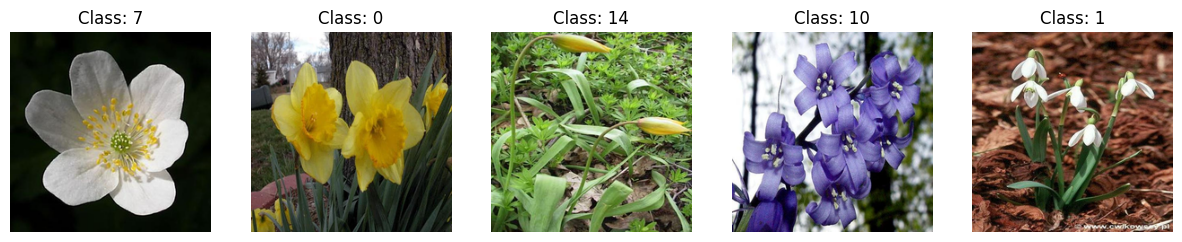

In [6]:
import matplotlib.pyplot as plt
def display_random_images(X, Y, num_images=5):
    random_indices = np.random.choice(X.shape[0], num_images, replace=False)
    plt.figure(figsize=(15, 7))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_images, i+1)
        plt.imshow(X[idx])
        plt.title(f'Class: {Y[idx]}')
        plt.axis('off')
    plt.show()

# Display 5 random images
display_random_images(X, Y)

B.Select any image from the dataset and assign it to a variable.

In [7]:
selected_image = X[0]
selected_label = Y[0]

print(f'Selected image shape: {selected_image.shape}')
print(f'Selected image class: {selected_label}')

Selected image shape: (224, 224, 3)
Selected image class: 9


C.Transform the image into grayscale format and display the same.

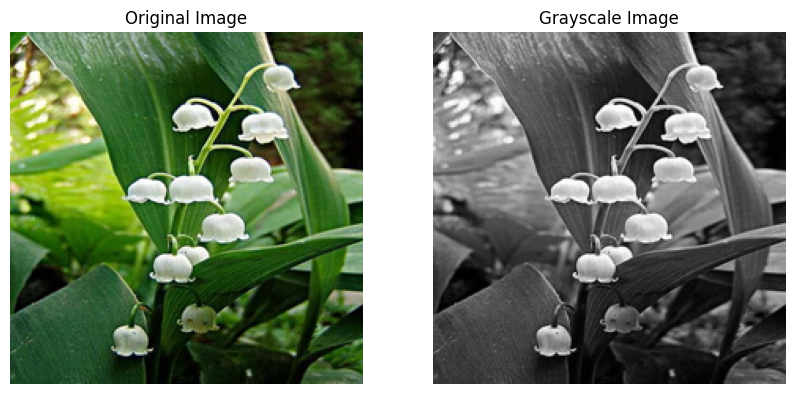

In [8]:
import cv2
grayscale_image = cv2.cvtColor(selected_image, cv2.COLOR_BGR2GRAY)

# Display the original and grayscale images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(selected_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(grayscale_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.show()

D.Apply a filter to sharpen the image and display the image before and after sharpening.

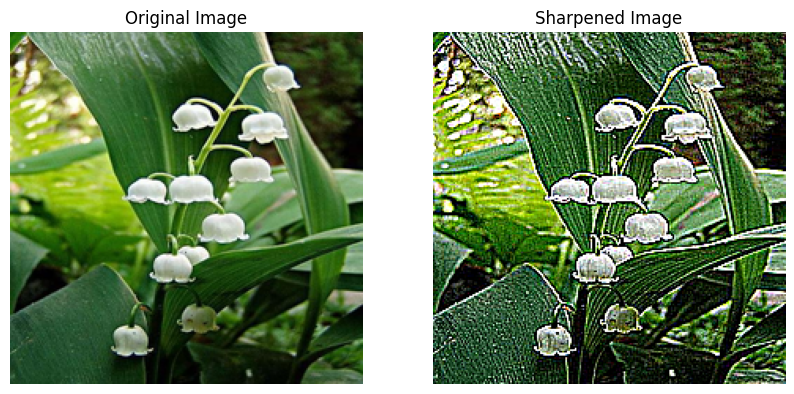

In [ ]:
grayscale_image = cv2.cvtColor(selected_image, cv2.COLOR_BGR2GRAY)

sharpening_kernel = np.array([[-1, -1, -1],
                              [-1,  9, -1],
                              [-1, -1, -1]])

sharpened_image = cv2.filter2D(selected_image, -1, sharpening_kernel)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(selected_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sharpened_image, cmap='gray')
plt.title('Sharpened Image')
plt.axis('off')

plt.show()

E.Apply a filter to blur the image and display the image before and after blur

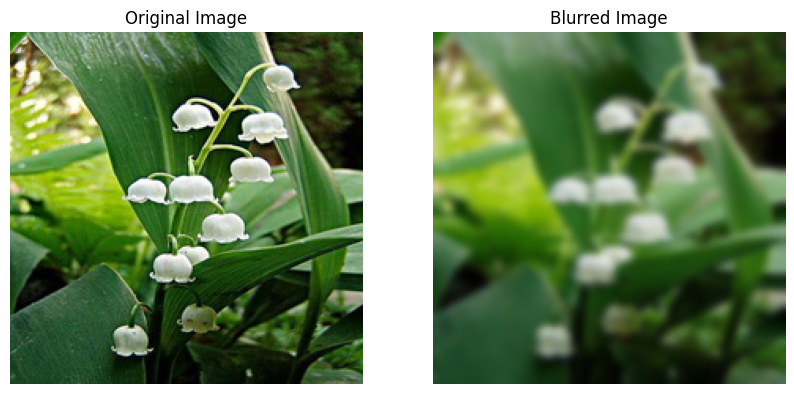

In [ ]:
kernel_size = (15, 15)
blurred_image = cv2.GaussianBlur(selected_image, kernel_size, 0)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(selected_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')

plt.show()


F.Display all the 4 images from above questions besides each other to observe the difference.

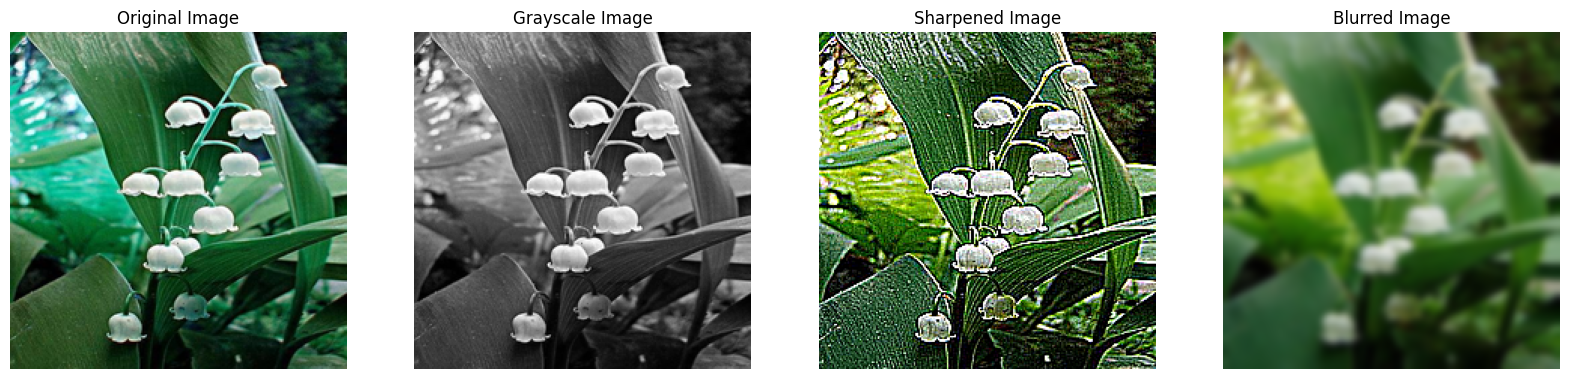

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(selected_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(grayscale_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(sharpened_image, cmap='gray')
plt.title('Sharpened Image')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')

plt.show()

A.Split the data into train and test with 80:20 proportion.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1088, 224, 224, 3)
Shape of y_train: (1088,)
Shape of X_test: (272, 224, 224, 3)
Shape of y_test: (272,)


B.Train a model using any Supervised Learning algorithm and share performance metrics on test data

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X_flat = X.reshape(X.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(X_flat, Y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

print(classification_report(y_test, y_pred))


Test Accuracy: 0.4743
              precision    recall  f1-score   support

           0       0.39      0.58      0.47        12
           1       0.33      0.19      0.24        21
           2       0.62      0.77      0.69        13
           3       0.44      0.25      0.32        16
           4       0.43      0.43      0.43        14
           5       0.25      0.14      0.18        21
           6       0.53      0.56      0.55        16
           7       0.50      0.54      0.52        13
           8       0.75      0.86      0.80        14
           9       0.23      0.36      0.28        14
          10       0.35      0.78      0.48         9
          11       0.55      0.25      0.34        24
          12       0.42      0.83      0.56        12
          13       0.67      0.57      0.62        14
          14       0.00      0.00      0.00        18
          15       0.60      0.50      0.55        18
          16       0.79      0.96      0.86        23

    

**C.Train a model using Neural Network and share performance metrics on test data**

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, classification_report

X_flat = X.reshape(X.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(X_flat, Y, test_size=0.2, random_state=42)

NN_model = Sequential()

NN_model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
NN_model.add(Dropout(0.5))
NN_model.add(Dense(128, activation='relu'))
NN_model.add(Dropout(0.3))
NN_model.add(Dense(64, activation='relu'))
NN_model.add(Dense(1, activation='sigmoid'))

NN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

NN_model.summary()

history = NN_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

y_pred_prob = NN_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

# Classification report (if applicable)
print(classification_report(y_test, y_pred))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               38535424  
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 38576641 (147.16 MB)
Trainable params: 3

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**D.Train a model using a basic CNN and share performance metrics on test data.**

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=17)
y_test = to_categorical(y_test, num_classes=17)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(17, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 128)      

**E.Predict the class/label of image ‘Prediction.jpg’ using best performing model and share predicted label.**

In [18]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = '/content/Prediction+-+Flower (1).jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

img_array /= 255.

predictions = model.predict(img_array)

predicted_class_index = np.argmax(predictions[0])

print("Predicted class index:", predicted_class_index)

1/1 [==============================] - 0s 129ms/step
Predicted class index: 7
